In [1]:
using Pkg
Pkg.activate("/media/mat/HDD/AdaptiveTransportMap/")

 Activating environment at `/media/mat/HDD/AdaptiveTransportMap/Project.toml`


In [2]:
using Revise
using LinearAlgebra
using AdaptiveTransportMap
using Statistics
using Distributions
using Test
using ForwardDiff
using SpecialFunctions
using OrthoMatchingPursuit
using BenchmarkTools

In [3]:
using Plots
default(tickfont = font("CMU Serif", 9), 
        titlefont = font("CMU Serif", 14), 
        guidefont = font("CMU Serif", 12),
        legendfont = font("CMU Serif", 10),
        grid = false)
# Plots.font("sans-serif")
# clibrary(:colorbrewer)
# gr()
pyplot()

using LaTeXStrings
# PyPlot.rc("text", usetex = "true")
# rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
# rcParams["text.usetex"] = true;
PyPlot.rc("font", family = "CMU Serif")
PyPlot.matplotlib[:rc]("mathtext",fontset="cm")        #computer modern font 
PyPlot.matplotlib[:rc]("font",family="serif",size=12)

In [67]:
Nx = 20
Ny = 5
r = min(4, min(Nx, Ny))
Ne = 500
H = randn(Ny, Nx)

σy = 0.1
Σy = Matrix(σy^2*I, Ny, Ny)
ϵy = AdditiveInflation(zeros(Ny), σy)

σx = 1.5
Σx = Matrix(σx^2*I, Nx, Nx)
L = cholesky(inv(Σx))
ϵx = AdditiveInflation(zeros(Nx), σx)

AdditiveInflation(20, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [2.25 0.0 … 0.0 0.0; 0.0 2.25 … 0.0 0.0; … ; 0.0 0.0 … 2.25 0.0; 0.0 0.0 … 0.0 2.25], [1.5 0.0 … 0.0 0.0; 0.0 1.5 … 0.0 0.0; … ; 0.0 0.0 … 1.5 0.0; 0.0 0.0 … 0.0 1.5])

In [68]:
H

5×20 Array{Float64,2}:
  1.40911   -0.542016  -1.29031   …  0.241828  0.452759    0.419904
  0.868259  -0.524189  -1.31347      0.930835  0.0105768   1.83061
 -0.152393  -0.138478  -0.185942     1.02781   1.18016    -0.316326
  2.07827   -0.208929   0.946394     1.75793   1.32969    -1.34708
  0.446048   0.2675     0.376995     1.19496   1.07575     0.277853

In [69]:
X = zeros(Ny+Nx, Ne)
ϵx(X, Ny+1, Ny+Nx)

In [70]:
xstar = σx*randn(Nx)
ystar = H*xstar

5-element Array{Float64,1}:
 -4.891984412355458
  8.865793079795054
  0.8786338833450253
  2.9121960760269476
 13.675396213887693

In [71]:
X

25×500 Array{Float64,2}:
  0.0         0.0           0.0        …   0.0        0.0         0.0
  0.0         0.0           0.0            0.0        0.0         0.0
  0.0         0.0           0.0            0.0        0.0         0.0
  0.0         0.0           0.0            0.0        0.0         0.0
  0.0         0.0           0.0            0.0        0.0         0.0
 -0.721047   -0.738251      2.96268    …   1.0146     2.06993     0.223161
  0.262601    1.27594       0.385642       1.25185    0.764466   -0.915046
 -0.840708   -2.77206      -3.67848       -0.31705   -0.0356741  -0.330502
 -1.98257     0.178815      1.5381         2.21129    0.0119122  -0.672179
  1.24507     2.03987       0.54293       -0.992132   0.678601    1.69698
  2.34897     2.52923      -0.0985964  …  -1.1775     1.05178     1.69108
 -0.258631   -0.00922065    0.78148        1.67597   -1.21641    -1.57921
  0.0244549  -0.423927     -1.47121       -1.98113    0.907536   -0.829277
 -0.699854    2.28294      -

In [72]:
# Compute observations
observe((x, t)->H*x, X, 0.0, Ny, Nx)

In [73]:
H*X[Ny+1:Ny+Nx,1]

5-element Array{Float64,1}:
 6.763675267042906
 6.262297250697275
 3.298216208409175
 1.3760444856512617
 1.2213196251252552

In [74]:
# Perturb observations
ϵy(X, 1, Ny)

In [75]:
H̃ = Σy^(-1/2)*H*Σx^(1/2)

5×20 Array{Float64,2}:
 21.1366   -8.13024  -19.3546    5.25464  …   3.62743   6.79139     6.29855
 13.0239   -7.86283  -19.7021    4.35763     13.9625    0.158651   27.4591
 -2.2859   -2.07717   -2.78913  -3.46195     15.4171   17.7024     -4.74489
 31.174    -3.13394   14.1959    7.92056     26.3689   19.9453    -20.2062
  6.69072   4.0125     5.65493  16.347       17.9244   16.1362      4.16779

In [76]:
svdH̃ = svd(H̃)
Λ = svdH̃.S
U = svdH̃.U
V = Matrix(svdH̃.Vt')

norm(U*Diagonal(Λ)*V'-H̃)

1.412212115435692e-13

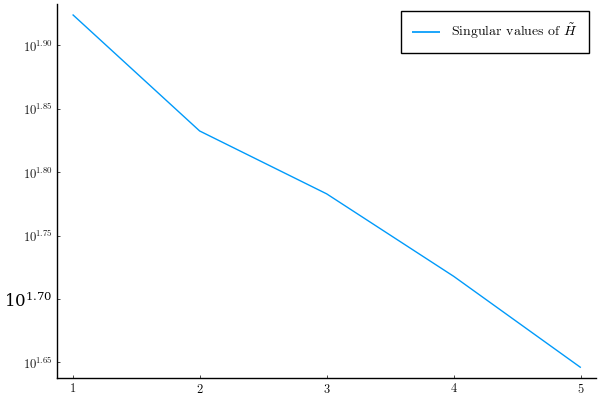

In [77]:
plot(Λ, yscale = :log10, label = L"Singular values of $\tilde{H}$")

In [78]:
Σy

5×5 Array{Float64,2}:
 0.01  0.0   0.0   0.0   0.0
 0.0   0.01  0.0   0.0   0.0
 0.0   0.0   0.01  0.0   0.0
 0.0   0.0   0.0   0.01  0.0
 0.0   0.0   0.0   0.0   0.01

In [79]:
X

25×500 Array{Float64,2}:
  6.73689     2.7492       13.7799     …   2.85384    4.91019     6.0684
  6.39059     1.27703       3.1138        -3.6761     2.33419     6.41564
  3.3852      5.86613      -0.203432       1.31903    5.90363     3.03739
  1.26476    -4.51075       4.58518       11.5688    -0.304026    6.74989
  1.19418     7.81381      -4.60762        5.43186    1.95165     6.67825
 -0.721047   -0.738251      2.96268    …   1.0146     2.06993     0.223161
  0.262601    1.27594       0.385642       1.25185    0.764466   -0.915046
 -0.840708   -2.77206      -3.67848       -0.31705   -0.0356741  -0.330502
 -1.98257     0.178815      1.5381         2.21129    0.0119122  -0.672179
  1.24507     2.03987       0.54293       -0.992132   0.678601    1.69698
  2.34897     2.52923      -0.0985964  …  -1.1775     1.05178     1.69108
 -0.258631   -0.00922065    0.78148        1.67597   -1.21641    -1.57921
  0.0244549  -0.423927     -1.47121       -1.98113    0.907536   -0.829277
 -0.69985

In [80]:
X̃ = copy(X)

25×500 Array{Float64,2}:
  6.73689     2.7492       13.7799     …   2.85384    4.91019     6.0684
  6.39059     1.27703       3.1138        -3.6761     2.33419     6.41564
  3.3852      5.86613      -0.203432       1.31903    5.90363     3.03739
  1.26476    -4.51075       4.58518       11.5688    -0.304026    6.74989
  1.19418     7.81381      -4.60762        5.43186    1.95165     6.67825
 -0.721047   -0.738251      2.96268    …   1.0146     2.06993     0.223161
  0.262601    1.27594       0.385642       1.25185    0.764466   -0.915046
 -0.840708   -2.77206      -3.67848       -0.31705   -0.0356741  -0.330502
 -1.98257     0.178815      1.5381         2.21129    0.0119122  -0.672179
  1.24507     2.03987       0.54293       -0.992132   0.678601    1.69698
  2.34897     2.52923      -0.0985964  …  -1.1775     1.05178     1.69108
 -0.258631   -0.00922065    0.78148        1.67597   -1.21641    -1.57921
  0.0244549  -0.423927     -1.47121       -1.98113    0.907536   -0.829277
 -0.69985

In [81]:
view(X̃,1:Ny, :) .= Σy^(-1/2)*view(X, 1:Ny, :)

5×500 view(::Array{Float64,2}, 1:5, :) with eltype Float64:
 67.3689   27.492   137.799    -15.5489  …   28.5384  49.1019   60.684
 63.9059   12.7703   31.138    -94.5085     -36.761   23.3419   64.1564
 33.852    58.6613   -2.03432   32.6517      13.1903  59.0363   30.3739
 12.6476  -45.1075   45.8518   -63.7749     115.688   -3.04026  67.4989
 11.9418   78.1381  -46.0762   -20.9632      54.3186  19.5165   66.7825

In [82]:
view(X̃,Ny+1:Ny+Nx, :) .= Σx^(-1/2)*view(X, Ny+1:Ny+Nx, :)

20×500 view(::Array{Float64,2}, 6:25, :) with eltype Float64:
 -0.480698   -0.492168      1.97512    …   0.6764      1.37996      0.148774
  0.175067    0.850626      0.257094       0.834568    0.509644    -0.61003
 -0.560472   -1.84804      -2.45232       -0.211366   -0.0237828   -0.220335
 -1.32171     0.11921       1.0254         1.47419     0.00794149  -0.448119
  0.830045    1.35991       0.361953      -0.661422    0.452401     1.13132
  1.56598     1.68615      -0.0657309  …  -0.784998    0.701185     1.12739
 -0.172421   -0.0061471     0.520987       1.11731    -0.810939    -1.05281
  0.0163032  -0.282618     -0.980805      -1.32076     0.605024    -0.552851
 -0.466569    1.52196      -1.72406        0.0961206  -0.0535712    0.785413
 -1.83228     1.13487      -0.799739       0.603159    0.872468    -0.888713
  0.840393    0.769438     -1.24538    …  -0.419878   -0.242655     0.549495
 -0.839614    0.159805     -0.662919       0.560732    0.384069    -0.906148
  0.514952    0.44

In [83]:
mean(X̃; dims = 2)

25×1 Array{Float64,2}:
 -1.190859588055337
 -1.4505144977075166
  1.8799998639441962
 -1.1413413875313005
  0.7525304747734491
 -0.012012397354705233
  0.08125875825474191
  0.004369024768454629
 -0.01947667691338518
  0.0322145132281514
  0.016636492948070254
  0.04093534093005781
  0.003597367264277463
  0.08728487643416864
 -0.003068959732943563
  0.01858964688454436
 -0.03360651020097653
  0.04040372256957499
  0.03011874333778825
 -0.004314165253695853
  0.018266503531407286
 -1.942492999486034e-5
 -0.009851313913650859
  0.04229082197693758
  0.018965684558384155

In [84]:
H̃ - Σy^(-1/2)*H*Σx^(1/2)

5×20 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [85]:
Klowrank = Σx^(1/2)*V*Diagonal(Λ)*inv(Diagonal(Λ.^2) + I)*U'*Σy^(-1/2)

20×5 Array{Float64,2}:
  0.0799001    0.0459225    -0.0391279    0.0590681   -0.0037944
 -0.0442336   -0.0347895    -0.00457919   0.00240568   0.025831
 -0.128956    -0.0868566    -0.00619665   0.0641194    0.0476603
  0.00849973   0.00788931   -0.0197304    0.0154248    0.0527424
  0.00326789   0.0243725    -0.0252055   -0.0617703    0.00223647
  0.0705999    0.0437444     0.0663125   -0.0470833   -0.0245542
  0.0126721   -0.0760775     0.0389684   -0.00858256  -0.10298
 -0.135202     0.0704237     0.118854    -0.0425032    0.0187456
 -0.0854715   -0.0282014     0.0748131   -0.00208668   0.0708745
 -0.0502587   -0.0396428    -0.00478685  -0.0293868   -0.00151952
  0.0474739   -0.0772957    -0.133008     0.0110138    0.0776262
 -0.0512187    0.0110071     0.00541875   0.0183413   -0.00211267
  0.0492673   -0.00448986    0.075208    -0.0226807    0.0119274
 -0.0374659    0.0585325     0.0348696    0.0961846   -0.0818002
 -0.0549619    0.0490853    -0.114216     0.0139114   -0.0460751
 -

In [86]:
K = Σx*H'*inv(H*Σx*H'+Σy)

20×5 Array{Float64,2}:
  0.0799001    0.0459225    -0.0391279    0.0590681   -0.0037944
 -0.0442336   -0.0347895    -0.00457919   0.00240568   0.025831
 -0.128956    -0.0868566    -0.00619665   0.0641194    0.0476603
  0.00849973   0.00788931   -0.0197304    0.0154248    0.0527424
  0.00326789   0.0243725    -0.0252055   -0.0617703    0.00223647
  0.0705999    0.0437444     0.0663125   -0.0470833   -0.0245542
  0.0126721   -0.0760775     0.0389684   -0.00858256  -0.10298
 -0.135202     0.0704237     0.118854    -0.0425032    0.0187456
 -0.0854715   -0.0282014     0.0748131   -0.00208668   0.0708745
 -0.0502587   -0.0396428    -0.00478685  -0.0293868   -0.00151952
  0.0474739   -0.0772957    -0.133008     0.0110138    0.0776262
 -0.0512187    0.0110071     0.00541875   0.0183413   -0.00211267
  0.0492673   -0.00448986    0.075208    -0.0226807    0.0119274
 -0.0374659    0.0585325     0.0348696    0.0961846   -0.0818002
 -0.0549619    0.0490853    -0.114216     0.0139114   -0.0460751
 -

In [87]:
norm(Klowrank-K)

4.723286913955599e-16

In [88]:
Xpost = deepcopy(X)

25×500 Array{Float64,2}:
  6.73689     2.7492       13.7799     …   2.85384    4.91019     6.0684
  6.39059     1.27703       3.1138        -3.6761     2.33419     6.41564
  3.3852      5.86613      -0.203432       1.31903    5.90363     3.03739
  1.26476    -4.51075       4.58518       11.5688    -0.304026    6.74989
  1.19418     7.81381      -4.60762        5.43186    1.95165     6.67825
 -0.721047   -0.738251      2.96268    …   1.0146     2.06993     0.223161
  0.262601    1.27594       0.385642       1.25185    0.764466   -0.915046
 -0.840708   -2.77206      -3.67848       -0.31705   -0.0356741  -0.330502
 -1.98257     0.178815      1.5381         2.21129    0.0119122  -0.672179
  1.24507     2.03987       0.54293       -0.992132   0.678601    1.69698
  2.34897     2.52923      -0.0985964  …  -1.1775     1.05178     1.69108
 -0.258631   -0.00922065    0.78148        1.67597   -1.21641    -1.57921
  0.0244549  -0.423927     -1.47121       -1.98113    0.907536   -0.829277
 -0.69985

In [89]:
view(Xpost, Ny+1:Ny+Nx, :) .= view(X,Ny+1:Ny+Nx,:) - Klowrank*(view(X,1:Ny,:) .- ystar)

20×500 view(::Array{Float64,2}, 6:25, :) with eltype Float64:
 -1.3885     -0.388919   1.52441    …   0.446284    1.9288    -0.708825
  1.02872     1.54203    1.47475        1.35228     1.3044    -0.334071
  1.15994    -1.65959   -1.01283       -0.566965    1.45718    0.970885
 -1.32873     0.695795   2.34191        2.55434     0.74722   -0.393565
  1.25672     1.88016    0.739059      -0.147507    0.759971   2.02799
  1.086       1.49757   -1.46361    …  -0.999746   -0.12705    0.890193
 -1.99143    -1.54507   -1.71899       -0.168126   -3.26826   -2.67626
  1.63705     0.345203   2.00078        0.419489    2.17862    0.862842
  0.917919    2.74885    0.227854       1.0219      1.02152    2.38825
 -2.31747     1.58233   -0.473007       1.04081     1.45414   -0.766868
  1.8376      1.40496   -1.9422     …  -1.36383     0.279661   0.902549
 -0.646295    0.811346  -0.0381655      1.1973      1.15704   -0.867745
  0.111382   -0.216173  -1.50284        0.144627    0.416603  -1.21129
  1.46

In [90]:
Xpost

25×500 Array{Float64,2}:
  6.73689     2.7492    13.7799     …   2.85384     4.91019    6.0684
  6.39059     1.27703    3.1138        -3.6761      2.33419    6.41564
  3.3852      5.86613   -0.203432       1.31903     5.90363    3.03739
  1.26476    -4.51075    4.58518       11.5688     -0.304026   6.74989
  1.19418     7.81381   -4.60762        5.43186     1.95165    6.67825
 -1.3885     -0.388919   1.52441    …   0.446284    1.9288    -0.708825
  1.02872     1.54203    1.47475        1.35228     1.3044    -0.334071
  1.15994    -1.65959   -1.01283       -0.566965    1.45718    0.970885
 -1.32873     0.695795   2.34191        2.55434     0.74722   -0.393565
  1.25672     1.88016    0.739059      -0.147507    0.759971   2.02799
  1.086       1.49757   -1.46361    …  -0.999746   -0.12705    0.890193
 -1.99143    -1.54507   -1.71899       -0.168126   -3.26826   -2.67626
  1.63705     0.345203   2.00078        0.419489    2.17862    0.862842
  0.917919    2.74885    0.227854       1.0219 

In [91]:
mean(state(Xpost, Ny, Nx); dims = 2)[:,1]

20-element Array{Float64,1}:
  0.11455888781735833
  0.3749517928568419
  0.67734919997317
  0.7516646601756366
  0.07841237454364597
 -0.3484693388252838
 -2.0842081223024165
  1.4936776465459254
  1.2940132477027377
 -0.23484449614002312
  0.10199654503096257
  0.32375135499484675
 -0.06948324305128244
 -0.04589870378883893
  0.034746584242670506
  1.9834430827948357
  0.4520788730071775
  1.8326848384197034
  1.2407985585163652
  0.44564117664541997

In [92]:
xstar

20-element Array{Float64,1}:
  0.1823912181057712
  1.6962334180236271
  0.02433059438339577
 -0.41938227806904216
 -0.861816161971601
 -0.3007009126908583
 -2.3606161493053808
 -0.2830595473570359
  1.9615936601858266
  0.7828355041945867
 -1.6224810399873466
 -0.16276924813973936
 -1.390189283515601
 -0.20989918453980172
 -0.434312585815559
  3.1816435142948833
  1.201749161892224
  2.0488017592255696
  0.9147103469532316
  0.4776891603062241

In [101]:
mean(state(X, Ny, Nx); dims = 2)[:,1] + K*(ystar - H*mean(state(X, Ny, Nx); dims = 2)[:,1])

20-element Array{Float64,1}:
  0.11403685023559404
  0.3750633231113875
  0.6778726840296159
  0.7512432490513574
  0.07819686680566594
 -0.348559186978047
 -2.083356596786177
  1.494362094747629
  1.2942831816969969
 -0.23455837676334176
  0.10107652706278011
  0.3239986903915998
 -0.06953405889145334
 -0.045192884172523075
  0.034786853071279426
  1.9830175079377241
  0.45164297670867226
  1.8327624634727637
  1.2409097002047855
  0.445034917496297

In [103]:
xstar

20-element Array{Float64,1}:
  0.1823912181057712
  1.6962334180236271
  0.02433059438339577
 -0.41938227806904216
 -0.861816161971601
 -0.3007009126908583
 -2.3606161493053808
 -0.2830595473570359
  1.9615936601858266
  0.7828355041945867
 -1.6224810399873466
 -0.16276924813973936
 -1.390189283515601
 -0.20989918453980172
 -0.434312585815559
  3.1816435142948833
  1.201749161892224
  2.0488017592255696
  0.9147103469532316
  0.4776891603062241

In [102]:
mean(state(X, Ny, Nx) ;dims = 2)[:,1]

20-element Array{Float64,1}:
 -0.018018596032057795
  0.12188813738211286
  0.006553537152681995
 -0.029215015370077695
  0.048321769842227066
  0.024954739422105424
  0.06140301139508675
  0.0053960508964161795
  0.13092731465125282
 -0.00460343959941531
  0.027884470326816485
 -0.050409765301464814
  0.06060558385436248
  0.04517811500668236
 -0.006471247880543713
  0.027399755297110938
 -2.9137394992339694e-5
 -0.014776970870476278
  0.06343623296540639
  0.028448526837576267